This script takes the 2016 DA Geometry file and the 2016 Statscan Census data, and creates a google Earth KMZ file for each province showing areas that are above and below certain population density thresholds.

Written by Tom Hastie
January 2020


In [1]:
%matplotlib inline


#import required libraries
from xml.etree import ElementTree as ET
from collections import defaultdict
from pyproj import Proj, transform, Transformer

import simplekml
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker


In [2]:
#function stolen from the internet. 
#It takes an XML tree (in this case the Census Data) and turns it into a python dictionary object. 

def etree_to_dict(t):
    d = {t.tag: {} if t.attrib else None}
    children = list(t)
    if children:
        dd = defaultdict(list)
        for dc in map(etree_to_dict, children):
            for k, v in dc.items():
                dd[k].append(v)
        d = {t.tag: {k: v[0] if len(v) == 1 else v
                     for k, v in dd.items()}}
    if t.attrib:
        d[t.tag].update(('@' + k, v)
                        for k, v in t.attrib.items())
    if t.text:
        text = t.text.strip()
        if children or t.attrib:
            if text:
              d[t.tag]['#text'] = text
        else:
            d[t.tag] = text
    return d

In [3]:
#DA geometry file location 
file_xml = 'DA_shape_file\\lda_000b16g_e.gml'

In [4]:
# open up file and parse xml tree using ElementTree module
tree = ET.parse(file_xml)

In [5]:
#get the DA UID, Name, and position list from the XML file. 
#put them in a python list for further processing.
i = 0
DA_list = []


for t in tree.iter('{http://www.safe.com/gml/fme}lda_000b16g_e'):
    DA = {}
    i+=1
    #print(t.findall('{http://www.safe.com/gml/fme}DAUID')[0].text)
    DA['UID'] = int(t.findall('{http://www.safe.com/gml/fme}DAUID')[0].text)
    DA['ERNAME'] = t.findall('{http://www.safe.com/gml/fme}ERNAME')[0].text
    
    
    #if len(t.findall('{http://www.opengis.net/gml}surfaceProperty')) is not 1:
    #    print(len(t.findall('{http://www.opengis.net/gml}surfaceProperty')))
        
    surface_list = []
    
    for surface in t.findall('{http://www.opengis.net/gml}surfaceProperty'):
        if surface:
            di = etree_to_dict(surface)
            surface_list.append(di)
            DA['surfaceProperty'] = surface_list
            #print(di)
        else:
            print(DA['UID'], DA['ERNAME'])
    for surface in t.findall('{http://www.opengis.net/gml}multiSurfaceProperty'):
        #print(surface)
        #print(DA['UID'])
        #print(DA['ERNAME'])
        di = etree_to_dict(surface)
        point_list = di['{http://www.opengis.net/gml}multiSurfaceProperty']['{http://www.opengis.net/gml}MultiSurface']['{http://www.opengis.net/gml}surfaceMember']
        #print(len(point_list))
        #print("Start_List")
        multi_surface_list = []
        for l in point_list:
            multi_surface_list.append(l['{http://www.opengis.net/gml}Surface']['{http://www.opengis.net/gml}patches']['{http://www.opengis.net/gml}PolygonPatch']['{http://www.opengis.net/gml}exterior']['{http://www.opengis.net/gml}LinearRing']['{http://www.opengis.net/gml}posList'])
        DA['multiSurface'] = multi_surface_list
        #print("End_list")
    DA_list.append(DA)
#print(i)

print("Number of Disemination Areas: %d"%len(DA_list))
print("Sample of data extracted:")
for DA in DA_list[0:2]:
    print(DA)

Number of Disemination Areas: 56589
Sample of data extracted:
{'UID': 10010244, 'ERNAME': 'Avalon Peninsula', 'surfaceProperty': [{'{http://www.opengis.net/gml}surfaceProperty': {'{http://www.opengis.net/gml}Surface': {'{http://www.opengis.net/gml}patches': {'{http://www.opengis.net/gml}PolygonPatch': {'{http://www.opengis.net/gml}exterior': {'{http://www.opengis.net/gml}LinearRing': {'{http://www.opengis.net/gml}posList': '8976851.14856922 2149576.54285611 8976818.14856922 2149509.53714611 8976752.55428422 2149542.32857111 8976560.31999922 2149661.59143111 8976490.55428422 2149705.07428611 8976354.78571422 2149785.82285611 8976272.75142922 2149821.67714611 8976190.13714422 2149866.79143111 8976195.66571422 2149883.50571611 8976260.85714422 2150016.91714611 8976273.13142922 2150051.04285611 8976272.92285422 2150083.44285611 8976265.71428422 2150121.91143111 8976382.41428422 2150157.02571611 8976439.10285422 2150180.22000111 8976482.51714422 2150206.11714611 8976587.63714422 2150288.980

In [6]:
#function that converts the statscanada map projection into standard WGS84 for Google Earth
def CRS_to_LL(CRS):
    ll_list = []
    inProj = Proj(init='epsg:3347')
    outProj = Proj(init='epsg:4326')
    for (x1, y1) in CRS:
        ll_list.append(transform(inProj,outProj,x1,y1))
    #print(ll_list)
    return(ll_list)

In [7]:
#faster version of the function above. Use this one, not the one above.
def CRS_to_LL(CRS, transformer):
    points = []
    for pt in transformer.itransform(point_tuples):
        points.append(pt[::-1])
    #print(ll_list)
    return(points)

In [8]:
#this is a testing cell. Don't run this cell 
test_DA = DA_list[1]
print(test_DA['ERNAME'])
#print(test_DA)
#print(test_DA['surfaceProperty'][0]['{http://www.opengis.net/gml}surfaceProperty']['{http://www.opengis.net/gml}Surface']['{http://www.opengis.net/gml}patches']['{http://www.opengis.net/gml}PolygonPatch']['{http://www.opengis.net/gml}exterior']['{http://www.opengis.net/gml}LinearRing']['{http://www.opengis.net/gml}posList'])

point_string = test_DA['surfaceProperty'][0]['{http://www.opengis.net/gml}surfaceProperty']['{http://www.opengis.net/gml}Surface']['{http://www.opengis.net/gml}patches']['{http://www.opengis.net/gml}PolygonPatch']['{http://www.opengis.net/gml}exterior']['{http://www.opengis.net/gml}LinearRing']['{http://www.opengis.net/gml}posList']

#convert the point list to a list of tuples
point_list = [float(i) for i in point_string.split()]
#print(point_list)
lat_CRS = point_list[1::2]
lon_CRS = point_list[::2]
point_tuples = [(y,x) for x,y in zip(lat_CRS, lon_CRS)]

print(point_tuples)
#points = CRS_to_LL(point_tuples)

transformer = Transformer.from_crs("EPSG:3347", "EPSG:4326")
points = []
for pt in transformer.itransform(point_tuples):
    points.append(pt[::-1])
    

print(points)






Avalon Peninsula
[(8977202.17999922, 2150836.79428611), (8977136.27714422, 2150650.26857111), (8977122.46571422, 2150596.22857111), (8977121.26856922, 2150564.04571611), (8977135.12571422, 2150492.93428611), (8977101.92571422, 2150483.54571611), (8977072.04571422, 2150475.00571611), (8977012.79714422, 2150458.65714611), (8976892.28285422, 2150426.98857111), (8976780.99428422, 2150389.63143111), (8976722.28571422, 2150362.41714611), (8976698.84571422, 2150446.45428611), (8976704.47714422, 2150513.22285611), (8976702.44571422, 2150543.01428611), (8976687.14571422, 2150575.49714611), (8976654.18571422, 2150614.93428611), (8976697.98285422, 2150649.80857111), (8976732.69142922, 2150654.29428611), (8976829.66571422, 2150653.51428611), (8976843.76285422, 2150656.44571611), (8976876.24571422, 2150671.74571611), (8976934.30571422, 2150689.70571611), (8977008.34285422, 2150723.27428611), (8977035.83142922, 2150743.62857111), (8977084.90285422, 2150807.51143111), (8977103.28856922, 2150819.88000

In [9]:
#take the list of all DAs in Canada and transform their coordinates to WGS84.
#then they get put in a list called "LL_list"
LL_list = []
transformer = Transformer.from_crs("EPSG:3347", "EPSG:4326")
for DA in DA_list:
    #print(DA['UID'], DA['ERNAME'])
    if 'surfaceProperty' in DA:
        point_string = DA['surfaceProperty'][0]['{http://www.opengis.net/gml}surfaceProperty']['{http://www.opengis.net/gml}Surface']['{http://www.opengis.net/gml}patches']['{http://www.opengis.net/gml}PolygonPatch']['{http://www.opengis.net/gml}exterior']['{http://www.opengis.net/gml}LinearRing']['{http://www.opengis.net/gml}posList']
        #print(len(point_string))
        point_list = [float(i) for i in point_string.split()]
        lat_CRS = point_list[1::2]
        lon_CRS = point_list[::2]
        point_tuples = [(y,x) for x,y in zip(lat_CRS, lon_CRS)]
        #print(len(point_tuples))
        points = CRS_to_LL(point_tuples, transformer)
        #print(points[0])
        DA["ll_points"] = [points]

    if 'multiSurface' in DA:
        #print(len(DA['multiSurface']))
        points = []
        for poly in DA['multiSurface']:
            point_list = [float(i) for i in poly.split()]
            lat_CRS = point_list[1::2]
            lon_CRS = point_list[::2]
            point_tuples = [(y,x) for x,y in zip(lat_CRS, lon_CRS)]
            ll_points = CRS_to_LL(point_tuples, transformer)
            #print(ll_points[0:10])
            points.append(ll_points)
        DA['ll_points'] = points
    LL_list.append(DA)



In [10]:
#print a random DA to check to see that the cell above worked.
for DA in DA_list:
    if DA['UID'] == 62080024:
        print(DA)

{'UID': 62080024, 'ERNAME': 'Nunavut', 'surfaceProperty': [{'{http://www.opengis.net/gml}surfaceProperty': {'{http://www.opengis.net/gml}Surface': {'{http://www.opengis.net/gml}patches': {'{http://www.opengis.net/gml}PolygonPatch': {'{http://www.opengis.net/gml}exterior': {'{http://www.opengis.net/gml}LinearRing': {'{http://www.opengis.net/gml}posList': '5692727.89142989 3672467.17428446 5692835.75714489 3672415.73714446 5692863.30571489 3672451.53142946 5692915.68571489 3672512.39714446 5692998.10856989 3672443.89714446 5693019.75428489 3672424.44856946 5693034.16285488 3672410.67999946 5693058.90285489 3672390.88856946 5693090.88571489 3672368.22285446 5693110.69714489 3672358.03428446 5693133.93714489 3672347.12571446 5693196.04571489 3672329.01999946 5693275.59999989 3672318.47428446 5693287.42571489 3672312.19714446 5693303.95714489 3672313.20285446 5693337.03714489 3672329.93999946 5693405.32233989 3672332.44512446 5693242.36856989 3672202.27999946 5693072.65428489 3672110.894284

In [11]:
#make a list of polygons as well as a list of UIDs for each DA. 
poly_list = []
UID_list = []
for DA in LL_list:
    #print(DA.keys())
    if 'll_points' in DA:
        poly_list.append(DA['ll_points'])
        UID_list.append(DA['UID'])
        
#print(poly_list[0])
#print(UID_list)

In [12]:
#load the census population data
filename = ["2016_census_data\\T1901EN.CSV"]
in_df = pd.read_csv(filename[0], engine = None, encoding = 'utf-8')
in_df.drop(in_df.tail(6).index,inplace=True) #drop the last few rows which aren't data

In [13]:
print(in_df.head())

  Geographic code Province / territory, english Province / territory, french  \
0        10010165     Newfoundland and Labrador      Terre-Neuve-et-Labrador   
1        10010166     Newfoundland and Labrador      Terre-Neuve-et-Labrador   
2        10010167     Newfoundland and Labrador      Terre-Neuve-et-Labrador   
3        10010168     Newfoundland and Labrador      Terre-Neuve-et-Labrador   
4        10010169     Newfoundland and Labrador      Terre-Neuve-et-Labrador   

   Geographic code, Province / territory  Geographic code, Census division  \
0                                   10.0                            1001.0   
1                                   10.0                            1001.0   
2                                   10.0                            1001.0   
3                                   10.0                            1001.0   
4                                   10.0                            1001.0   

   Geographic code, Census subdivision  Population

In [14]:
#convert the Geographic ID to a numeric
in_df['Geographic code'] = pd.to_numeric(in_df['Geographic code'])

In [15]:
#had trouble putting a list of lists into a pandas cell... so lets make a dictionary for lookup. 
DA_positions = {}
DA_ERNAME = {}
for DA in DA_list:
    DAUID = DA['UID']
    DA_positions[DAUID] = DA['ll_points']
    DA_ERNAME[DAUID] = DA['ERNAME']
    

In [16]:
#get a list of the provinces in the census data. We'll use this to generate the file names of hte kmz
provinces = in_df['Province / territory, english'].unique()
print(provinces)

['Newfoundland and Labrador' 'Prince Edward Island' 'Nova Scotia'
 'New Brunswick' 'Quebec' 'Ontario' 'Manitoba' 'Saskatchewan' 'Alberta'
 'British Columbia' 'Yukon' 'Northwest Territories' 'Nunavut']


In [17]:
#make a graph of land area available vs. population density. 

density_vector = [0, 0.1, 1,2,5, 10, 20, 25, 50]
area_vector = [0 for i in range(len(density_vector))]
print(density_vector)
print(area_vector)

[0, 0.1, 1, 2, 5, 10, 20, 25, 50]
[0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
total_area = 0

for idx, r in in_df.iterrows():
    land_area = r['Land area in square kilometres, 2016']
    pop_density = r['Population density per square kilometre, 2016']
    total_area+=land_area
    for i, d in enumerate(density_vector):
        if pop_density<=d:
            area_vector[i] += land_area
print(area_vector)
    
print(total_area)

[7097603.489999995, 7483713.049999991, 8308629.14999999, 8503106.729999987, 8684695.719999976, 8794122.489999974, 8872868.859999971, 8890088.399999969, 8923053.429999977]
8965590.680000143


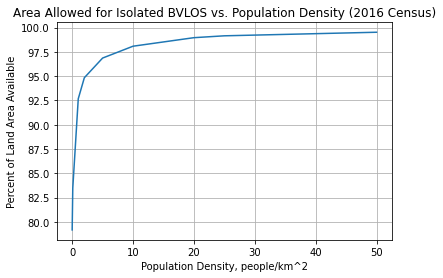

In [19]:

# Data for plotting
t = density_vector
#myList[:] = [x / myInt for x in myList]
s = [x*100/total_area for x in area_vector]

fig, ax = plt.subplots()
ax.plot(t, s)

ax.set(xlabel='Population Density, people/km^2', ylabel='Percent of Land Area Available',
       title='Area Allowed for Isolated BVLOS vs. Population Density (2016 Census)')
ax.grid()

fig.savefig("Landmass vs Pop Density.png")
plt.show()

In [20]:
#Main loop... go through each province, and for each make a kmz file that has GREEN
#for areas with less than the density_threshold number of people, and RED
#for areas with more. 


density_threshold =5

for province in provinces:
    print(province)
    province_df = in_df[in_df['Province / territory, english'] == province]
    
    kmz_filename = province + ".kmz"
    kml = simplekml.Kml()
    #kml.document.description = description_string
    high_density_folder = kml.newfolder(name=str("More than %d people per square kilometer."%density_threshold))
    low_density_folder  = kml.newfolder(name=str("Less than %d people per square kilometer."%density_threshold))
    for index, row in province_df.iterrows():
        DAUID = row['Geographic code']
        #print(DAUID)
        
        #fol = kml.newfolder(name=str(DAUID))
        if int(DAUID) in DA_positions:
            for i, ring in enumerate(DA_positions[int(DAUID)]):

                #create a description string for each polygon:
                description_string = "DA_UID: %s"%DAUID
                description_string += "\nPopulation: %s"%row['Population, 2016']
                description_string += "\nPopulation Density: %s"%row['Population density per square kilometre, 2016']
                #print(description_string)
                #print(i, len(ring))
                #print(ring)
                
                if row['Population density per square kilometre, 2016'] >= density_threshold:
                    pol = high_density_folder.newpolygon(name=DA_ERNAME[DAUID],
                                     outerboundaryis=ring,
                                        description=description_string)
                    pol.style.polystyle.color = simplekml.Color.changealphaint(200, simplekml.Color.red)
                else:
                    pol = low_density_folder.newpolygon(name=DA_ERNAME[DAUID],
                                     outerboundaryis=ring,
                                        description=description_string)
                    pol.style.polystyle.color = simplekml.Color.changealphaint(200, simplekml.Color.green)
                    
    #print(kml.kml())
    kml.savekmz(kmz_filename)

Newfoundland and Labrador
Prince Edward Island
Nova Scotia
New Brunswick
Quebec
Ontario
Manitoba
Saskatchewan
Alberta
British Columbia
Yukon
Northwest Territories
Nunavut


In [ ]:
#Main loop... go through each province, and for each make a kmz file that has show a range of population densities. 
#given a vector of densities make some coloured folders. 




density_threshold = [5, 10, 15, 20, 100, 200]
land_areas = [0.] * len(density_threshold)
print(land_areas)
#colours = red, orange, yellow, green, blue, purple
colours = ['99000000',
           simplekml.Color.blue, 
           simplekml.Color.green, 
           simplekml.Color.yellow, 
           simplekml.Color.orange,
           simplekml.Color.red]
#colours = [simplekml.Color.yellow, simplekml.Color.red]



for province in provinces:
    print(province)
    province_df = in_df[in_df['Province / territory, english'] == province]
    
    kmz_filename = province + ".kmz"
    kml = simplekml.Kml()
    #kml.document.description = description_string
    folder1 = kml.newfolder(name=str("More than %d people per square kilometer."%density_threshold[0]))
    folder2  = kml.newfolder(name=str("More than %d people per square kilometer."%density_threshold[1]))
    folder3  = kml.newfolder(name=str("More than %d people per square kilometer."%density_threshold[2]))
    folder4  = kml.newfolder(name=str("More than %d people per square kilometer."%density_threshold[3]))
    folder5  = kml.newfolder(name=str("More than %d people per square kilometer."%density_threshold[4]))
    folder6  = kml.newfolder(name=str("More than %d people per square kilometer."%density_threshold[5]))
    folders = [folder1, folder2, folder3, folder4, folder5, folder6]
    for index, row in province_df.iterrows():
        DAUID = row['Geographic code']
        #print(DAUID) 
        
        #fol = kml.newfolder(name=str(DAUID))
        if int(DAUID) in DA_positions:
            for i, ring in enumerate(DA_positions[int(DAUID)]):

                #create a description string for each polygon:
                description_string = "DA_UID: %s"%DAUID
                description_string += "\nPopulation: %s"%row['Population, 2016']
                description_string += "\nPopulation Density: %s"%row['Population density per square kilometre, 2016']
                #print(description_string)
                #print(i, len(ring))
                #print(ring)
                
                for i, density in enumerate(density_threshold):
                    if row['Population density per square kilometre, 2016'] >= density:
                        pol = folders[i].newpolygon(name=DA_ERNAME[DAUID],
                                         outerboundaryis=ring,
                                            description=description_string)
                        pol.style.polystyle.color = simplekml.Color.changealphaint(200, colours[i])
                        #sum the land area so we can figure out how much land is covered by each population density.
                        land_areas[i] += row['Land area in square kilometres, 2016']
    print(land_areas)
                    
    #print(kml.kml())
    #print(land_areas)
    kml.savekmz(kmz_filename)

In [ ]:
#Make a separate file for each population density



density_threshold = [5, 10, 15, 25]
land_areas = [0.] * len(density_threshold)
print(land_areas)
#colours = red, orange, yellow, green, blue, purple
colours = ['99000000',
           simplekml.Color.blue, 
           simplekml.Color.green, 
           simplekml.Color.yellow, 
           simplekml.Color.orange,
           simplekml.Color.red]




for density in density_threshold:
    print(density)
    density_df = in_df[in_df['Population density per square kilometre, 2016'] > density]
    
    kmz_filename = str(density) + ".kmz"
    kml = simplekml.Kml()
    #kml.document.description = description_string
    folder1 = kml.newfolder(name=str("More than %d people per square kilometer."%density))
    folders = [folder1]
    for index, row in density_df.iterrows():
        DAUID = row['Geographic code']
        #print(DAUID)
        
        #fol = kml.newfolder(name=str(DAUID))
        if int(DAUID) in DA_positions:
            for i, ring in enumerate(DA_positions[int(DAUID)]):

                #create a description string for each polygon:
                description_string = "DA_UID: %s"%DAUID
                description_string += "\nPopulation: %s"%row['Population, 2016']
                description_string += "\nPopulation Density: %s"%row['Population density per square kilometre, 2016']
                #print(description_string)
                #print(i, len(ring))
                #print(ring)
                
                
                pol = folders[0].newpolygon(name=DA_ERNAME[DAUID],
                                 outerboundaryis=ring,
                                    description=description_string)
                pol.style.polystyle.color = simplekml.Color.changealphaint(200, colours[5])
                #sum the land area so we can figure out how much land is covered by each population density.
                #land_areas[i] += row['Land area in square kilometres, 2016']
    print(land_areas)
                    
    #print(kml.kml())
    #print(land_areas)
    kml.savekmz(kmz_filename)